# ST7 Planification quotidienne d’une équipe mobile
# Phase III

## Importation de modules

In [44]:
# module importation
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import itertools

# utilities
from utils import *
from copy import deepcopy

# model classes for employees and nodes
from models_v2 import Employee, Node, Task, Home, Unavail

from Greedy_sol import GreedySolution

Déclaration des constantes et des indices :

In [45]:
W = U = T = V = 0
employees = homes = tasks = unavails = nodes = []

## Fonction de lecture de données

In [46]:
def load_data_from_path(path_to_instance: str):
    # load employee data
    Employee.load_excel(path_to_instance)

    # load node data
    Node.clear_previous_data()
    for cls in [Home, Task, Unavail]:
        cls.load_excel(path_to_instance)
    Node.initialize_distance()

    # constants
    global W, U, T, V
    (W, U, T, V) = (Task.count, Unavail.count, Employee.count, Node.count)

    # indices of employees, homes, lunches, tasks, unavailabilities
    global employees, homes, tasks, unavails, nodes
    employees = list(range(T))
    homes = list(range(T))
    tasks = list(range(T, T + W))
    unavails = list((range(T + W, V)))
    nodes = list(range(V))

def temps(v1,v2):
    return ceil(Node.distance[v1,v2]/Employee.speed)

Lecture de données de test

In [47]:
path_to_test = path_columbia_v3 = "./data/InstancesV3/InstanceColumbiaV3.xlsx"
load_data_from_path(path_to_test)

## Implémentation des classesopérations et solution

In [48]:
class Operation:
    def __init__(self,type,node=-1,employee1=-1,employee2=-1):
        self.type = type
        self.node = node
        self.employee1 = employee1
        self.employee2 = employee2

    def copy(self):
        """Return a deep copy of the instance"""
        return deepcopy(self)

class Solution:
    print_warning = True  # whether to print warning or not when validating

    def __init__(self,chemins):
        self.list = chemins
        self.lunch_times = {}
    
    @classmethod
    def set_warning(cls, print_warning: bool):
        """set whether to print warning when validating data"""
        cls.print_warning = print_warning

    @classmethod
    def warn(cls, warning: str, print_color="yellow"):
        """
        Print a text in yellow if print_warning set to True
        :param warning: the warning message we want to print
        :param print_color: the color of the printed message, defaulted to yellow
        """
        if not cls.print_warning: return # does nothing if print_warning set to False
        correspondance = {
            "yellow": Colors.WARNING,
            "cyan": Colors.CYAN,
            "green": Colors.GREEN,
            "red": Colors.FAIL
        }
        color = correspondance[print_color] if print_color in correspondance.keys() else Colors.WARNING
        print(f"{color}Error: {warning}{Colors.NORMAL}")

    def copy(self):
        """Return a deep copy of the instance"""
        return deepcopy(self)

    def validate_format(self):
        """Verify that Solution and margin have the right format"""
        if type(self.list) == str :
            Solution.warn(self.list)
            return False

        for k in self.list.keys():
            if k not in employees :
                Solution.warn(f"{k} is not the index of an employee")
                return False
            for v in list(self.list[k].keys())[1:] : 
                if v not in tasks + unavails: 
                    Solution.warn(f"{v} is not the index of a task or an unvavailability")
                    return False
        return True

    def validate(self):
        """
        validate the modifications
        :return: whether the constraints are verified
        """

        # verify that x, y and l contain only 0 and 1
        if not self.validate_format(): return False

        # C1, okay thank to the format 

        # C2
        visited = []
        for k in self.list.keys():
            for v in self.list[k].keys():
                if v in visited :
                    Solution.warn("C2: Each task should be done by at most one employee.")
                    Solution.warn(f"Condition violated by node {v} done by employees {k}.", "cyan")
                    return False
                visited.append(v)

        # C3.a and C3.b2
        for v in unavails :
            for k in self.list.keys() :
                if Node.list[v].employee.index_of() == k and not v in self.list[k].keys():
                    Solution.warn("C3.a: Unavailabilities should be visited.")
                    Solution.warn(f"Condition violated by node {v}.", "cyan")
                    return False

        for k in self.list.keys():
            if list(self.list[k].keys())[0] != k:
                Solution.warn(f"C3.b: Each employee should visits their home.")
                Solution.warn(f"Condition violated by employee {k}.", "cyan")
                return False

        # C4, okay thank to the format 

        # C5 + C6.b
        for k in self.list.keys():
            delta1 = 0
            delta2 = 0
            for v in self.list[k].keys(): 
                if v == k :
                    continue
                self.list[k][v][0] += delta1

                opening, closing = Node.list[v].opening_time, Node.list[v].closing_time
                m = self.list[k][v][1] - opening
                if m<0 :
                    Solution.warn(f"C5: A task should be worked on between its opening time and closing time")
                    Solution.warn(f"Condition violated by task {v}", "cyan")
                    return False
                if  opening > self.list[k][v][0] :
                    delta1 += opening - self.list[k][v][0]
                    self.list[k][v][0] = opening
                
                m = closing - (self.list[k][v][0] + Node.list[v].duration)
                if m<0 :
                    Solution.warn(f"C5: A task should be worked on between its opening time and closing time")
                    Solution.warn(f"Condition violated by task {v}", "cyan")
                    return False
                if  closing < self.list[k][v][1] + Node.list[v].duration:
                    self.list[k][v][1] = closing - Node.list[v].duration

                if v in unavails :
                    self.list[k][v][0] = opening
                    self.list[k][v][1] = opening

            for i in range(len(self.list[k].keys())-1, 1, -1):
                v1 = list(self.list[k].keys())[i]
                v2 = list(self.list[k].keys())[i-1]
                delta =  Node.list[v2].duration + temps(v1,v2)
                new_t2 = self.list[k][v1][1] - delta
                if new_t2 < self.list[k][v2][0] :
                    Solution.warn(f"C5: A task should be worked on between its opening time and closing time")
                    Solution.warn(f"Condition violated by task {v2}", "cyan")
                    return False
                else :
                    self.list[k][v2][1] = min(self.list[k][v2][1],new_t2)
        # C6.a + 
        for k in self.list.keys():
            if len(list(self.list[k].keys())) == 1: continue
            v = list(self.list[k].keys())[1]
            if v not in unavails :
                if self.list[k][v][0] < Employee.list[k].start_time :
                    Solution.warn(f"C6.a: Employees' start times should be respected")
                    Solution.warn(f"Condition violated by employee {k}", "cyan")
                    return False

        # C7
        # TODO: verify C7

        # C8
        # TODO: verify C8

        # C9
        for k in self.list.keys():
            if len(list(self.list[k].keys())) == 1 : continue
            v = list(self.list[k].keys())[-1]
            if self.list[k][v][1] + Node.list[v].duration + temps(v,k) > Employee.list[k].end_time :
                Solution.warn("C9: An employee should have enough time to go back home.")
                Solution.warn(f"Condition violated by employee {k} after task {v}", "cyan")
                return False

        # C10
        for k in self.list.keys() :
            Lunch_Break = False
            for i in range(len(self.list[k].keys())):
                v = list(self.list[k].keys())[i]
                t1,t2 = self.list[k][v]
                if t1<= 13*60 and t2>=13*60 and t2-t1>=60 :
                    '''on a espoire de pouvoir placer la pause déjeuner avant la tâche v'''
                    if t1<=12*60:
                        t_end_lunch = 13*60
                    else :
                        t_end_lunch = t1+60
                    def rec(i,t):
                        '''on vérifie que l'insertion du déjeuner ne dérange pas la suite de la journée'''
                        if i==len(self.list[k].keys()):
                            '''On est arrivé à la fin de la journée sans soucis'''
                            return True
                        else :
                            v1 = list(self.list[k].keys())[i-1]
                            v2 = list(self.list[k].keys())[i]
                            t1,t2 = self.list[k][v2]
                            if v1 == k:
                                d = temps(v1,v2)
                            else :
                                d = Node.list[v1].duration + temps(v1,v2)
                            T = t + d
                            if T>t2:
                                '''Le décalage introduit par le lunch ne permet pas de réaliser les tâches'''
                                return False
                            if T<=t1 :
                                '''Le décalage permet la réalisation de la tâche 
                                et n'implique aucune modification dans la suite de la journée'''
                                return True
                            else :
                                return rec(i+1,T)
                    Lunch_Break = rec(i+1,t_end_lunch)
                    if Lunch_Break : 
                        self.list[k][v][0] = t_end_lunch
                        def rec2(i,t):
                            '''On modifie les créneaux possible de ralisation des tâches
                            suite à l'insertion du lunch'''
                            if i==len(self.list[k].keys()):
                                return
                            else :
                                v1 = list(self.list[k].keys())[i-1]
                                v2 = list(self.list[k].keys())[i]
                                t1,t2 = self.list[k][v2]
                                if v1 == k:
                                    d = temps(v1,v2)
                                else :
                                    d = Node.list[v1].duration + temps(v1,v2)
                                T = t + d
                                self.list[k][v2][0] = max(T,t1)
                                if T<=t1 :
                                    return 
                                else :
                                    return rec2(i+1,T)
                        n = rec2(i+1,t_end_lunch)
                        self.lunch_times[k] = t_end_lunch - 60
                        break
            
            if not Lunch_Break and v>=len(self.list.keys()) and t1 + Node.list[v].duration <= 13*60 :
                if Employee.list[k].end_time >= max(t1 + Node.list[v].duration,12*60) + 60 +temps(v,k) :
                    self.lunch_times[k] = max(t1 + Node.list[v].duration,12*60)
                    self.list[k][v][1] = min(self.lunch_times[k] - Node.list[v].duration,t2)
                    Lunch_Break = True
            elif not Lunch_Break and v <len(self.list.keys()):
                self.lunch_times[k] = 12*60
                self.list[k][v][1] = 12*60
                Lunch_Break = True
                    
            if not Lunch_Break :
                Solution.warn("C10: Each employee must have the time to lunch")
                Solution.warn(f"Condition violated by employee {k}", "cyan")
                return False

        # C12
        for k in self.list.keys():
            for i in range(len(self.list[k].keys())-1):
                v1 = list(self.list[k].keys())[i]
                v2 = list(self.list[k].keys())[i+1]
                if i == 0 and self.list[k][v1][0] + temps(v1,v2) > self.list[k][v2][1] :
                    Solution.warn("C12: The traveling time between two nodes should be sufficient.")
                    Solution.warn(f"Condition violated between node {v1} and {v2}", "cyan")
                    return False

        # C13
        for k in self.list.keys():
            for v in self.list[k].keys():
                if v in tasks and Employee.list[k].level < Node.list[v].level :
                    Solution.warn("C13: An employee can only do tasks that they are able to do.")
                    Solution.warn(f"Condition violated by employee {k} at node {v}", "cyan")
                    return False

        # Every condition is verified
        return True

# Demo
On peut instancier une nouvelle instance de Solution en appelant simplement le constructeur Solution().
L’instance s’adapte alors automatiquement aux données présentes dans les classes Employee et Node

La méthode validate permet de déterminer si notre solution vérifie les contraintes. Lorsque au moins une contrainte n’est pas vérifiée. Dans ce cas-là, un message d’erreur correspondant à la première violation de contrainte s’affiche.

In [49]:
#solution_instance = Solution()
#solution_instance.validate()

Pour modifier une solution, on modifie directement les tableaux numpy stockés en attribut des instances.

In [50]:
#solution_instance.x[0, 0] = 1
#solution_instance.validate()

Pour copier une instance, on utilise la méthode copy(), qui fait un deep-copy de l’instance.

In [51]:
#solution_instance_copy = solution_instance.copy()

Lorsque l’on modifie une copie, la solution originale n’est pas modifiée.

In [52]:
#solution_instance_copy.x[0, 0] = 2
#solution_instance.x[0, 0] = 0
#solution_instance.x[1, 0] = solution_instance.x[0, 2] = 1

In [53]:
#solution_instance.validate()

In [54]:
#solution_instance_copy.validate()

L'affichage des contraintes non vérifiées sont pour le debug, et on peut ne pas les afficher lorsque l’on exécute nos algorithmes méta-heuristiques.

In [55]:
#Solution.set_warning(False) # this tells the solution class to not print warning messages
#solution_instance.validate()

In [56]:
#Solution.set_warning(True) # modify setting to print warning messages again
#solution_instance.validate()

In [57]:
# Tabu Search

# Définition des objets

def evaluate(routes):
    ''' Renvoie les valeurs des fonctions objectifs associé à l'instances représentée par "routes" '''
    total_task_duration = 0
    total_distance = 0
    for route in routes :
        for i in range(1,len(route)) :
            if route[i] not in unavails :
                total_task_duration += Node.list[route[i]].duration
            total_distance += Node.distance[route[i-1],route[i]]
        total_distance += Node.distance[route[-1],route[0]]
    return (total_task_duration, total_distance)

def compare(a,b):
    '''Renvoie True si la solution b est meilleurs que la solution b'''
    if a[1] > b[1] :
        return True
    elif a[1] == b[1] and a[0] < b[0] :
        return True
    return False

def compare2(a,b):
    '''Renvoie True si la solution b est meilleurs que la solution b'''
    if a[0] < b[0] :
        return True
    elif a[0] == b[0] and a[1] > b[1] :
        return True
    return False

def simple_sol(route):
    '''Renvoie une solution simple dont les tâches de l'employé route[0] on été remplacées par route'''
    sol =[]
    for i in range(len(Employee.list)):
        sol.append([i])
    for v in unavails :
        employee = Node.list[v].employee
        employee_idx = Employee.index_of(employee)
        sol[employee_idx].append(v)
    sol[route[0]] = route
    return sol

def add_time(routes):
    '''Permet de calculer pour chaque tâche le temps au quel la tâche peut-être commencée au plus tôt et au plus tard.
    Le calcul ne prend en compte que les horaires de l'employé, la durée des tâches et les temps de parcours entre celles ci'''
    routes_timed = {}
    for k in range(len(routes)):
        routes_timed[k] = {}
        v0 = routes[k][0]
        routes_timed[k][v0] = Employee.list[k].start_time
        for i in range(1,len(routes[k])):
            v1 = routes[k][i-1]
            v2 = routes[k][i]
            if i == 1 :
                d = temps(v1,v2)
            else :
                if v1<len(Employee.list):
                    return "Not Possible"
                d = Node.list[v1].duration + temps(v1,v2)
            routes_timed[k][v2] = routes_timed[k][v1] + d
        
        v = routes[k][-1]
        if v<len(routes):
            margin = Employee.list[k].end_time - (routes_timed[k][v] + temps(v,v0))
        else :
            margin = Employee.list[k].end_time - (routes_timed[k][v] + Node.list[v].duration + temps(v,v0))
        if margin <0 :
            return "Not Possible"
        else :
            for i in range(len(routes[k])):
                v = routes[k][i]
                routes_timed[k][v] = [routes_timed[k][v],routes_timed[k][v]+margin]
    return routes_timed


# Définition de la list Tabou

def update_tabu(Tabu_list, operations, iter, tabu_step):
    '''Ajoute à la liste tabou les opérations et retire les opérations qui sont restées dans la liste le temps suffisant'''
    nb_op = len(operations)
    for i in range(nb_op):
        Tabu_list[iter+i/nb_op] = operations[i]
    for key in list(Tabu_list.keys()) :
        if key < iter - tabu_step +1 :
            del Tabu_list[key]

def tabu_of(op):
    '''Pour une opération retourne l'opération "contraire" qui doit être ajoutée à la liste tabou'''
    if op.type == "Adding":
        non_op = op.copy()
        non_op.type = "Deleting"
        return non_op
    elif op.type == "Deleting":
        non_op = op.copy()
        non_op.type = "Adding"
        return non_op
    else:
        return op

def op_in(op,dict_op):
    '''Renvoie True si l'opération "op" est dans les valeurs du dictionnaire "dict_op"'''
    for op2 in list(dict_op.values()):
        if op.type == op2.type and op.node == op2.node and op.employee1 == op2.employee1 and op.employee2 == op2.employee2 :
            return True
    return False


# Définition du voisinage

def Crossing(route1, route2, max_len_cross):
    '''Renvoie les voisins issues du mélange des deux routes'''
    Neighbors = []
    n1 = len(route1)
    n2 = len(route2)
    for l1 in range(max_len_cross+1):
        for l2 in range(max_len_cross+1): 
            if l1 == 0 and l2 ==0:
                continue
            for i in range(1,n1-l1):
                for j in range(1,n2-l2):
                    new_route1 = route1[:i]+route2[j:j+l2]+route1[i+l1:]
                    new_route2 = route2[:j]+route1[i:i+l1]+route2[j+l2:]
                    Neighbors.append((new_route1,new_route2))
    return Neighbors

def Switching(route):
    '''Renvoie toutes les permutation des tâches de la trajectoire "route"'''
    Neighbors = []
    permutations = list(itertools.permutations(route[1:]))
    for p in permutations :
        Neighbors.append([route[0]]+[x for x in p])
    return Neighbors

def Adding_Node(route,unvisited_nodes):
    '''Renvoie toutes les routes, venant de l'ajout d'une tâche alors non visitée dans la route originelle'''
    Neighbors = []
    for node in unvisited_nodes :
        for i in range(len(route)):
                Neighbors.append((route[:i+1]+[node]+route[i+1:],node))
    return Neighbors

def Deleting_Node(route):
    '''Renvoie toutes les routes, venant de la suppression d'une tâche dans la route originelle'''
    Neighbors = []
    for i in range(1,len(route)):
        if route[i] not in unavails:
            Neighbors.append((route[:i]+route[i+1:], route[i]))
    return Neighbors

def local_neighbor_switching(route,Tabu_list):
    '''Renvoie la route faisable, issue d'une permutation de "route", 
    ayant les meilleurs valeurs des fonction objectifs'''
    candidate_list = Switching(route)
    local_obj_values = (0,10**10)
    local_op = None
    for candidate in candidate_list:
        op = Operation(type = "Switching", employee1=route[0])
        if not op_in(op, Tabu_list) and Solution(add_time(simple_sol(candidate))).validate() :
            obj_values = evaluate([candidate])
            if compare(local_obj_values, obj_values) :
                local_sol = candidate
                local_obj_values = obj_values
                local_op = op

    return local_sol, local_op

def local_neighbor_adding(route,unvisited_nodes,Tabu_list):
    '''Renvoie la route faisable, issue d'un ajout de tâche dans "route", 
    ayant les meilleurs valeurs des fonction objectifs'''
    candidate_list = Adding_Node(route,unvisited_nodes)
    local_obj_values = (0,10**10)
    add_node = -1
    local_op = None
    for candidate, node in candidate_list:
        op = Operation(type = "Adding", node = node, employee1 = route[0])
        if not op_in(op,Tabu_list) and Solution(add_time(simple_sol(candidate))).validate() :
            obj_values = evaluate([candidate])
            if compare(local_obj_values, obj_values) :
                local_sol = candidate
                local_obj_values = obj_values
                add_node = node
                local_op = op

    if add_node == -1:
        return route, None

    del unvisited_nodes[add_node]

    return local_sol, local_op

def create_neighborhood(routes, unvisited_nodes, status, max_len_cross, Tabu_list):
    '''Renvoie les meilleurs voisins de la solution routes, selon le status de voisinage désiré.
    Adding : on ajoute des tâches;
    Switching : On permute les tâches aux seins des trajectoires des employés;
    Deleting : On retire une tâche.'''
    T = len(routes)

    if status == "adding":
        operations = []
        new_route = []
        for i in range(T):
            Neighbor,op = local_neighbor_adding(routes[i],unvisited_nodes,Tabu_list)
            if Neighbor != routes[i]:
                operations.append(op)
                Neighbor, op = local_neighbor_switching(Neighbor,Tabu_list)
            new_route.append(Neighbor)
        Neighborhood = [(new_route,operations)]
        
    elif status == "switching":
        operations = []
        new_route = []
        for i in range(T):
            Neighbor, op = local_neighbor_switching(routes[i],Tabu_list)
            new_route.append(Neighbor)
            operations.append(op)
        Neighborhood = [(new_route,operations)]

    elif status == "deleting":
        local_obj_values = (0,10**10)
        del_node = -1
        local_op = None
        local_employee = -1
        for i in range(T):
            Neighbors = Deleting_Node(routes[i])
            for candidate, node in Neighbors:
                new_routes = routes[:i]+[candidate]+routes[i+1:]
                obj_values = evaluate([candidate])
                op = Operation(type = "Deleting", node = node, employee1 = candidate[0])
                if compare(local_obj_values, obj_values) :
                    local_sol = new_routes
                    local_obj_values = obj_values
                    del_node = node
                    local_op = op
                    local_employee = candidate[0]
        
        if del_node == -1:
            Neighborhood = [(routes, [local_op])]

        else :
            unvisited_nodes[del_node] = None
            Neighbor, op = local_neighbor_switching(routes[local_employee],Tabu_list)
            Neighborhood = [(local_sol, [local_op])]

    else :
        Neighborhood = []
        local_obj_values = (0,10**10)
        local_op = None
        for i in range(T):
            for j in range(i+1,T):
                Neighbors = Crossing(routes[i], routes[j], max_len_cross)
                for (route1,route2) in Neighbors:
                    op = Operation(type = "Exchange", employee1 = route1[0], employee2 = route2[0])
                    if not op_in(op, Tabu_list) and Solution(add_time(simple_sol(route1))).validate() and Solution(add_time(simple_sol(route2))).validate() :
                        obj_values = evaluate([route1,route2])
                        if compare(local_obj_values, obj_values) :
                            local_sol = route1,route2
                            local_obj_values = obj_values
                            local_op = op
        if local_obj_values == (0,10**10):
            return [(routes, [local_op])]
        local_sol = local_neighbor_switching(local_sol[0],Tabu_list)[0],local_neighbor_switching(local_sol[1],Tabu_list)[0]
        local_sol = routes[:local_sol[0][0]]+[local_sol[0]]+routes[local_sol[0][0]+1:local_sol[1][0]]+[local_sol[1]]+routes[local_sol[1][0]+1:]
        Neighborhood = [(local_sol, [local_op])]

    return Neighborhood

# Initialisation / 1ère solution
def sol_init(type):
    '''Renvoie une solution initiale calculée rapidement'''
    if type == "glouton":
        sol = GreedySolution()
        sol.optimize_employee_by_employee()
    elif type == "clustering":
        sol = None
    else :
        sol =[]
        for i in range(len(Employee.list)):
            sol.append([i])
        for v in unavails :
            employee = Node.list[v].employee
            employee_idx = Employee.index_of(employee)
            sol[employee_idx].append(v)
    return sol

def search_unvisited_nodes(sol):
    '''Revoie un dictionnaire dont les clés sont les tâches non efféctuées par la solution "sol"'''
    unvisited_nodes = {}
    for i in range(len(Node.list)):
        unvisited_nodes[i] = None
    for route in sol:
        for node in route :
            del unvisited_nodes[node]
    return unvisited_nodes

# Itérations

def tabu_search(init_sol = "glouton",max_it = 30, tabu_step = 10, max_len_cross = 10, block_max = 3):
    '''Exécution de l'algorithme tabou'''
    sol = sol_init(init_sol)
    sol_list = [sol]
    best_obj_values = evaluate(sol)
    Tabu_list = {0 : Operation(type = "None")}
    block_count = 0
    unvisited_nodes = search_unvisited_nodes(sol)
    climbing = True
    for it in range(1,max_it):
        block_count += 1

        if block_count >= block_max :
            neighborhood = create_neighborhood(sol_list[-1], unvisited_nodes, "deleting", max_len_cross, Tabu_list)
            block_count = 0
            climbing = True
        elif climbing :
            neighborhood = create_neighborhood(sol_list[-1], unvisited_nodes, "adding", max_len_cross,Tabu_list)
            if [neighborhood[0][1][i] for i in range(len(neighborhood[0][1]))] == [None]*len(neighborhood[0][1]) :
                climbing = False
            else :
                block_count = 0
                
        if not climbing :
            neighborhood = create_neighborhood(sol_list[-1], unvisited_nodes, " ", max_len_cross, Tabu_list)
            if [neighborhood[0][1][i] for i in range(len(neighborhood[0][1]))] == [None]*len(neighborhood[0][1]) :
                neighborhood = create_neighborhood(sol_list[-1], unvisited_nodes, "deleting", max_len_cross, Tabu_list)
                block_count = 0

        local_sol, local_operations = neighborhood[0]
        local_obj_values = evaluate(local_sol)

        update_tabu(Tabu_list, local_operations, it, tabu_step)
        sol_list.append(local_sol)

        if compare2(best_obj_values, local_obj_values):
            sol = local_sol
            best_obj_values = local_obj_values
            block_count = 0

        print(it, local_obj_values)
    return sol, best_obj_values


In [58]:
Solution.set_warning(False)
#create_neighborhood([[0,10,7,4,6,12],[1,5,8,11,9]], [3],10)

X = Solution(add_time(sol))

X.validate()


True

In [59]:
#Bordeaux V2 : 1,100,200,20
sol, obj = tabu_search()

NameError: name 'i' is not defined

In [ ]:
evaluate(sol)
Sol_timed = Solution(add_time(sol))

Sol_timed.validate()

True

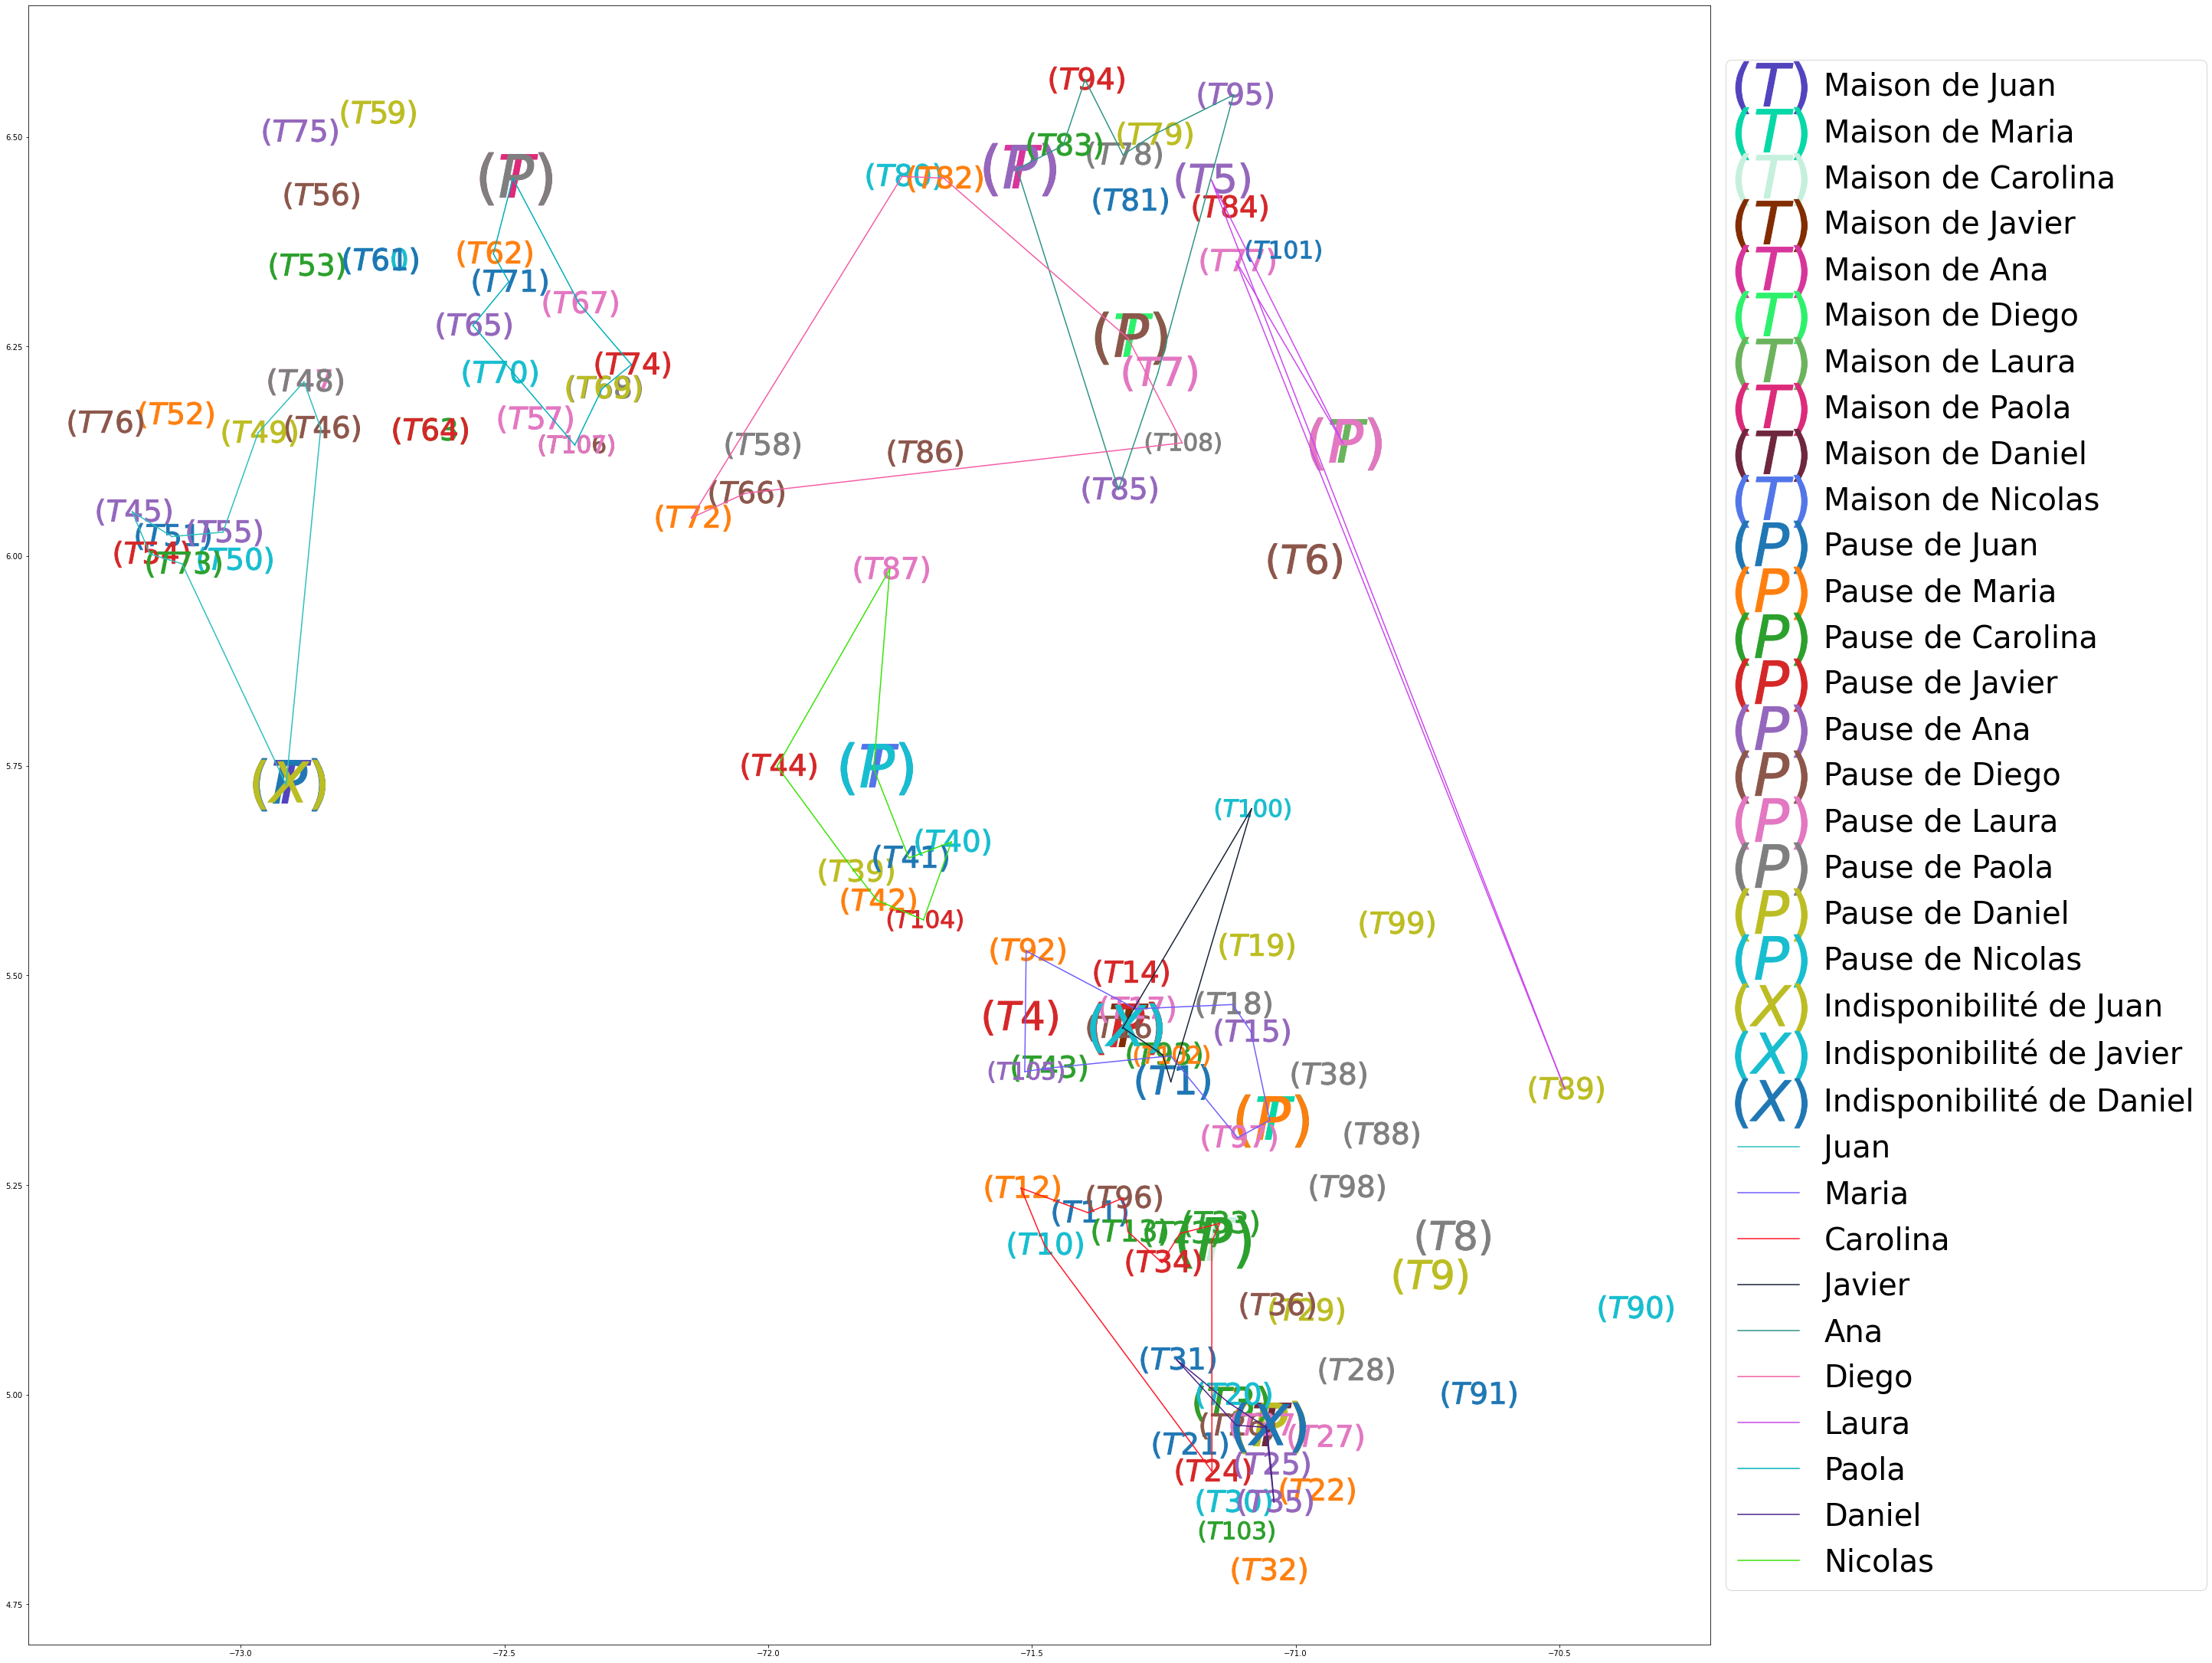

NameError: name 'plot_agenda_V3' is not defined

In [ ]:
X = {}
for k in range(len(sol)):
    for i in range(1,len(sol[k])):
        X[(sol[k][i-1],sol[k][i])] = 1
    X[(sol[k][-1],sol[k][0])] = 1

L = {}
for k in range(len(sol)):
    L[(k,k)] = 1

Z = {}
for k in range(len(sol)):
    for i in range(len(sol[k])):
        Z[sol[k][i]] = k 

B = {}
for k in range(len(sol)):
    for v in sol[k]:
        B[v] = Sol_timed.list[k][v][0]

lunch_times = {}
for k in range(len(sol)):
    for v in sol[k]:
        lunch_times[k] = Sol_timed.lunch_times[k]



In [ ]:
def store_result_V3(target_path, employees, tasks, lunch_times, z, b):
    w, t = len(tasks), len(employees)
    with open(target_path, "w") as f:
        f.write("taskId;performed;employeeName;startTime; \n")
        for i in tasks:
            if i in z.keys():
                f.write(f"T{i -t + 1};1;{employees[z[i]].name};{b[i]};\n")
            else:
                f.write(f"T{i - t + 1};0;;;\n")
        f.write("\n")
        f.write("employeeName;lunchBreakStartTime;\n")
        for k in range(t):
            f.write(f"{employees[k].name};{lunch_times[k]};\n")
    return

store_result_V3("./results/Tabu/SolutionColumbiaV3byV3.txt", Employee.list, tasks, lunch_times, Z, B)

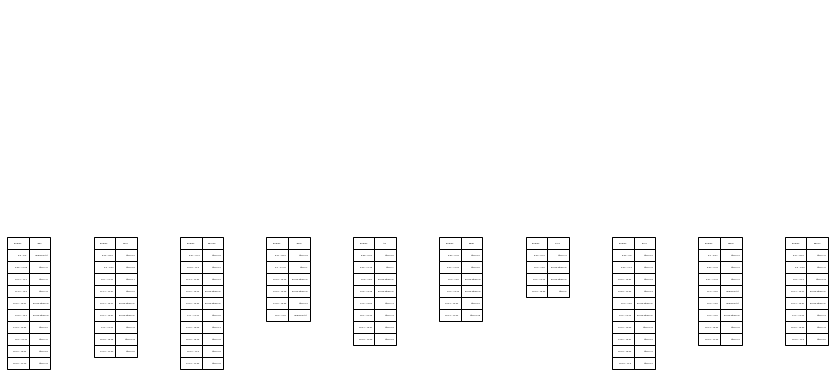

In [ ]:
def plot_agenda_V3(employee_list, node_list, tasks, unavails, B, Z,lunch_times):
    N = len(employee_list)
    left, width = 0.1, 2.0
    bottom, height = 0.1, 0.8

    Table = {k : [left + width/N*k, bottom, width/N - 0.1, height] for k in range(N)}

    Ax = {k : plt.axes(Table[k], frameon =False) for k in range(N)}

    plan = [[] for i in range(N)]

    for t in tasks:
        if t in Z.keys():
            plan[Z[t]].append((B[t],f"tâche {t-N+1}"))
            plan[Z[t]].append((B[t]+node_list[t].duration,f"tâche {t-N+1}"))
    for k in range(N):
        plan[k].append((lunch_times[k],f"pause déjeuner"))
        plan[k].append((lunch_times[k]+60,f"pause déjeuner"))
    for u in unavails:
        plan[Z[u]].append((B[u],f"indisponibilité"))
        plan[Z[u]].append((B[u]+node_list[t].duration,f"indisponibilité"))

    column_labels=[[] for i in range(N)]
    for k in range(N) :
        column_labels[k].append("horaires")
        column_labels[k].append(f"{employee_list[k].name}")

    for k in range(N):
        plan[k].sort(key= lambda x: x[0])

        chose = []
        for i in range(0,len(plan[k])-1,2):
            chose.append([f"{time_format(plan[k][i][0])} - {time_format(plan[k][i+1][0])}",plan[k][i][1]])
        plan[k] = chose
        
    for k in range(N) :
        Ax[k].axis('tight')
        Ax[k].axis('off')
        Ax[k].table(cellText=plan[k],colLabels=column_labels[k])

    plt.show()

plot_agenda_V3(Employee.list, Node.list, tasks, unavails, B, Z, lunch_times)

In [ ]:
def plot_map_V3(employee_list, node_list, tasks, unavails, X, L, Z):
    plt.figure(figsize=(cm_to_inch(100), cm_to_inch(100)))

    node_pos = []
    for employee in employee_list:
        node_pos.append([employee.longitude, employee.latitude])
        rd_color = "#" + ''.join([rd.choice('0123456789ABCDEF') for _ in range(6)])
        plt.scatter([employee.longitude], [employee.latitude], label=f"Maison de {employee.name}", c=rd_color,
                    marker="$(T)$", s=10000)

    t = len(employee_list)
    all_indexes = list(range(t)) + tasks + unavails

    for k in range(t):
        for i in all_indexes:
            if (k,i) in L.keys() and L[(k, i)] == 1:
                employee = employee_list[k]
                node = node_list[i]
                plt.scatter([node.longitude], [node.latitude], label=f"Pause de {employee.name}", marker="$(P)$",
                            s=10000)

    for i in tasks:
        task = node_list[i]
        node_pos.append([task.longitude, task.latitude])
        plt.scatter([task.longitude], [task.latitude], marker = f"$({task.id})$", s = 10000)

    for i in unavails:
        unavail = node_list[i]
        node_pos.append([unavail.longitude, unavail.latitude])
        plt.scatter([unavail.longitude], [unavail.latitude], label="Indisponibilité de " + unavail.employee.name,
                    marker="$(X)$", s=10000)

    number_of_colors = len(Employee.list)  # hardcoded
    color = ["#" + ''.join([rd.choice('0123456789ABCDEF') for _ in range(6)])
             for _ in range(number_of_colors)]

    n = len(node_pos)
    for a in range(n):
        for b in range(n):
            i = all_indexes[a]
            j = all_indexes[b]
            if i != j and (i,j) in X.keys() and X[(i, j)] == 1:
                lbl = ""
                clr = "black"
                if i in range(t):
                    lbl = f"{employee_list[Z[j]].name}"
                    clr = color[Z[i]]
                elif j in range(t):
                    clr = color[Z[j]]
                else:
                    clr = color[Z[i]]

                plt.plot([node_pos[a][0], node_pos[b][0]], [node_pos[a][1], node_pos[b][1]], c= clr, label = lbl)

    plt.legend(prop={'size': 40},loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plot_map_V3(Employee.list, Node.list, tasks, unavails, X, L, Z)